# Autoencoder Learning Experiment
In this version, we try not to generate data based on real formants, but instead a toy data that roughly reflects the distribution but somewhat seems like the normalized version without being really normalized. This is mainly to tackle the problem of different ranges of variances for different formants, which should be tied to their specific means (larger value range, larger variance values)

In version 3, we additionally compare the model with very little cross-phonemic contrast

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import calendar;
import time; # Importing necessary libraries
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader

## Generate Dataset

In [2]:
def generate_gmm_data(d, n_components=4, random_state=42, num_data=1000, 
                            means=None, vars=None, sizes=None, tags=None):
    """
    Generate a GMM dataset with exact cluster sizes and custom string labels.

    - sizes: list of exact number of samples for each component; sum(sizes) == num_data
    - tags: list of string labels for each component

    Returns:
    - X: (num_data, d)
    - labels: (num_data,) array of strings (from tags)
    """
    rng = np.random.default_rng(random_state)

    if sizes is None:
        sizes = [num_data // n_components] * n_components
        sizes[-1] += num_data - sum(sizes)
    else:
        sizes = list(sizes)
        assert len(sizes) == n_components, "Sizes must match the number of components"
        num_data = sum(sizes)   # adjust num_data to match sizes

    if tags is None:
        tags = [str(i) for i in range(n_components)]
    else:
        assert len(tags) == n_components

    if means is None:
        means = rng.uniform(-20, 20, size=(n_components, d))
    else:
        means = np.array(means, dtype=float)
        assert means.shape == (n_components, d)

    if vars is None:
        covariances = [np.diag(rng.uniform(0.1, 0.2, size=d)) for _ in range(n_components)]
    else:
        covariances = [np.diag([var]*d) for var in vars]

    X = []
    labels = []
    for k in range(n_components):
        Xk = rng.multivariate_normal(means[k], covariances[k], size=sizes[k])
        X.append(Xk)
        labels.extend([tags[k]] * sizes[k])
    X = np.vstack(X)
    labels = np.array(labels)
    perm = rng.permutation(num_data)
    return X[perm], labels[perm]

def zscore_normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0, ddof=0)

In [3]:
def plot_2d_projection_with_principal_axes(X, labels, dim_x=0, dim_y=1, label_names=None):
    """
    X: (N, d) array (d >= 2)
    labels: length-N int or string labels
    dim_x, dim_y: which dimensions to plot (0-based)
    label_names: list of label strings, or None to skip legend
    """
    # Map string labels to numeric for color
    label_names_unique, labels_numeric = np.unique(labels, return_inverse=True)
    
    # Compute mean and covariance in full space
    mu = X.mean(axis=0)
    C = np.cov(X, rowvar=False)
    U, S, Vt = np.linalg.svd(C)

    # 2D mean for plot
    mu2 = mu[[dim_x, dim_y]]

    plt.figure(figsize=(7, 7))
    # Scatterplot of projection
    plt.scatter(X[:, dim_x], X[:, dim_y], c=labels_numeric, alpha=0.6, cmap='tab10', label='')

    # Draw and label first two principal axes, projected
    for i in range(2):
        vec = U[:, i] * np.sqrt(S[i])
        vec2 = vec[[dim_x, dim_y]]
        plt.arrow(mu2[0], mu2[1], vec2[0], vec2[1], width=0.05, length_includes_head=True, label=f'σ{i+1}')
        plt.arrow(mu2[0], mu2[1], -vec2[0], -vec2[1], width=0.05, length_includes_head=True)
        plt.text(mu2[0] + vec2[0]*1.1, mu2[1] + vec2[1]*1.1, f'{S[i]:.2f}', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.xlabel(f"Dimension {dim_x+1}")
    plt.ylabel(f"Dimension {dim_y+1}")
    plt.title("GMM Samples: Principal Axes & Singular Values (Projected)")
    plt.grid(True)

    # Legend with class names, if available
    if label_names is not None:
        for i, name in enumerate(label_names_unique):
            plt.scatter([], [], c=[plt.cm.tab10(i)], label=name)
        plt.legend(title="Class")

    plt.show()

    # 1) Covariance matrix heatmap
    C = np.cov(X, rowvar=False)
    plt.figure()
    plt.imshow(C, aspect='equal')
    plt.colorbar()
    plt.title("Covariance Matrix")
    plt.xlabel("Dimension")
    plt.ylabel("Dimension")
    plt.show()

    # 2) Singular values
    U, S, Vt = np.linalg.svd(C)
    plt.figure()
    plt.bar(np.arange(1, len(S)+1), S)
    plt.xlabel("Component")
    plt.ylabel("Singular Value")
    plt.title("Singular Values of Covariance Matrix")
    plt.show()

## Generate Both Training and Testing Data

### Case 1: one contrast direction in training

In [ ]:
# training means and shared std
means_train = [
    # np.array([120.0, 320.0, 1650.0, 2250.0]),  # /y/
    # np.array([120.0, 320.0,  800.0, 2250.0]),  # /u/
    np.array([0.0, 0.0, -10.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 10.0, 0.0]),  # /u/
]
var_strength = 2.0  # Hz in all dimensions
vars_train = [var_strength, var_strength]
sizes_train = [500, 500]  # for example
tags_train = ["y", "u"]

means_test = [
    np.array([0.0, 5.0, -10.0, 0.0]),  # /ø/
    np.array([0.0, 5.0, 10.0, 0.0]),  # /o/
    np.array([0.0, 10.0, -10.0, 5.0]),  # /ɛ/
    np.array([0.0, 10.0, 10.0, 5.0]),  # /ʌ/
    np.array([0.0, 0.0, -10.0, 5.0]),  # /i/
    np.array([0.0, 0.0, -10.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 10.0, 0.0]),  # /u/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [50] * len(means_test)  # for example
tags_test = ["ø", "o", "ɛ", "ʌ", "i", "y", "u"]

data_train, labels_train = generate_gmm_data(d=4, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=4, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

### DataLoaders

## Define Model

In [5]:
# Define a simple 2-layer linear autoencoder
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

## Training Settings

## Training

In [6]:
class LinearAutoEncoder():
    '''Neural network class'''
    def __init__(self):
        self.history = {'loss': [], 'val_loss': [], 'weights': {'W1':[], 'W2':[]}, 'activations': [], 'testing_activations': []}
    
    def train(self, X, X_val=None, input_dim=5, n_epoch=100, hidden_dim=100, learning_rate=0.1, reg_param=0.0001, 
              noise='gaussian', noise_scale=1, verbose=False, Y=None, Y_val=None):
        """
        Y: testing data
        """
        self.y_val = Y_val
        dtype = torch.cuda.FloatTensor
        X_in = X.clone().type(dtype)
        X = X.type(dtype)
        N = X.shape[0]
        D = X.shape[1]
        
        self.strenghts = torch.zeros((1, D)).type(dtype)
        self.W1 = 0.0001*torch.randn(X.shape[1], hidden_dim).type(dtype)
        self.W2 = 0.0001*torch.randn(hidden_dim, input_dim).type(dtype)

        W = self.W1.mm(self.W2)
        s_int = np.linalg.svd(W.cpu().numpy(), compute_uv=0)
        self.init = np.sum(s_int[:100])/len(s_int)
        
        for t in range(n_epoch):
            
            W1 = self.W1
            W2 = self.W2
            
            # compute scores
            h1 = X_in.mm(W1)
            scores = h1.mm(W2)

            # compute loss
            data_loss = 0.5*((scores - X).pow(2).sum())/N
            noise_loss = 0.5*noise_scale*torch.trace(W2.t().mm(W1.t()).mm(W1).mm(W2))
            reg_loss = 0.5*reg_param*torch.sum(W1*W1) + 0.5*reg_param*torch.sum(W2*W2)
            loss = data_loss + noise_loss + reg_loss
                    
            # store loss
            self.history['loss'].append(loss)
        
            # compute the gradient using backpropagation
            dscores = (scores - X)/N
            dW2 = h1.t().mm(dscores)
            dhidden = dscores.mm(W2.t())
            dW1 = X_in.t().mm(dhidden)
            
            # add regularisation gradients
            dW2 += reg_param*W2
            dW1 += reg_param*W1
            
            # add noise gradients
            dW1 += noise_scale*W1.mm(W2).mm(W2.t())
            dW2 += noise_scale*W1.t().mm(W1).mm(W2)

            # perform parameter updates
            self.W1 += -learning_rate*dW1
            self.W2 += -learning_rate*dW2
            
            # compute validation loss
            if X_val is not None:
                val_pred = self.predict(X_val)
                val_loss = 0.5*(X_val - val_pred).pow(2).sum()/N
                self.history['val_loss'].append(val_loss)
                if verbose:
                    if t % 100 == 0:
                        print('iteration: ', t, 'training loss: ', loss, ' validation loss: ', val_loss)
            else:
                if verbose:
                    if t % 100 == 0:
                        print('iteration: ', t, 'training loss: ', loss)
            
            # compute eigenvalues
            if t % 1 == 0:
                W = self.W1.mm(self.W2)
                # W = self.W1
                s = np.linalg.svd(W.cpu().numpy(), compute_uv=0)
                s = torch.unsqueeze(torch.from_numpy(s).type(dtype), 1).t()
                self.strenghts = torch.cat((self.strenghts, s), dim=0)

                testing_activations = self.encode(Y.type(dtype))
                
                self.history['weights']['W1'].append(W1.cpu().numpy().copy())
                self.history['weights']['W2'].append(W2.cpu().numpy().copy())
                self.history['activations'].append(h1.cpu().numpy().copy())
                self.history['testing_activations'].append(testing_activations.cpu().numpy().copy())
        
    def predict(self, X):
        W1 = self.W1
        W2 = self.W2
        h1 = X.type(torch.cuda.FloatTensor).mm(W1)
        scores = h1.mm(W2)
        return scores
    
    def encode(self, X):
        W1 = self.W1
        W2 = self.W2
        h1 = X.type(torch.cuda.FloatTensor).mm(W1)
        # scores = h1.mm(W2)
        return h1

In [150]:
# training means and shared std
means_train = [
    # np.array([120.0, 320.0, 1650.0, 2250.0]),  # /y/
    # np.array([120.0, 320.0,  800.0, 2250.0]),  # /u/
    np.array([0.0, 0.0, -10.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 10.0, 0.0]),  # /u/
    np.array([0.0, 5.0, -10.0, 0.0]),  # /ø/
    np.array([0.0, 5.0, 10.0, 0.0]),  # /o/
]
var_strength = 5.0  # Hz in all dimensions
vars_train = [var_strength] * len(means_train)
sizes_train = [100 // len(means_train)] * len(means_train)  # for example
tags_train = ["y", "u", "ø", "o"]

means_test = [
    np.array([0.0, 5.0, -10.0, 0.0]),  # /ø/
    np.array([0.0, 5.0, 10.0, 0.0]),  # /o/
    np.array([0.0, 10.0, -10.0, 5.0]),  # /ɛ/
    np.array([0.0, 10.0, 10.0, 5.0]),  # /ʌ/
    np.array([0.0, 0.0, -10.0, 5.0]),  # /i/
    np.array([0.0, 0.0, -10.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 10.0, 0.0]),  # /u/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [50] * len(means_test)  # for example
tags_test = ["ø", "o", "ɛ", "ʌ", "i", "y", "u"]

data_train, labels_train = generate_gmm_data(d=4, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=4, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

In [151]:
# set parameters
num_samples = sum(sizes_train)
epochs = 5000
lr = 0.0005
reg_param = 0.1
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()

# set seed
np.random.seed(123)
torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):
t = 0
laeModel = LinearAutoEncoder()
laeModel.train(input_data, None, input_dim=4, 
                n_epoch=epochs, hidden_dim=hidden_dim, 
                learning_rate=lr, reg_param=reg[t], 
                noise='Gaussian', noise_scale=var[t], verbose=True, 
                Y=torch.from_numpy(data_test).float(), 
                Y_val=labels_test)
recorded_models.append(laeModel)

iteration:  0 training loss:  tensor(66.5565, device='cuda:0')
iteration:  100 training loss:  tensor(66.5451, device='cuda:0')
iteration:  200 training loss:  tensor(16.7621, device='cuda:0')
iteration:  300 training loss:  tensor(14.0395, device='cuda:0')
iteration:  400 training loss:  tensor(14.0394, device='cuda:0')
iteration:  500 training loss:  tensor(14.0389, device='cuda:0')
iteration:  600 training loss:  tensor(14.0355, device='cuda:0')
iteration:  700 training loss:  tensor(14.0149, device='cuda:0')
iteration:  800 training loss:  tensor(13.8877, device='cuda:0')
iteration:  900 training loss:  tensor(13.1509, device='cuda:0')
iteration:  1000 training loss:  tensor(10.0739, device='cuda:0')
iteration:  1100 training loss:  tensor(5.8306, device='cuda:0')
iteration:  1200 training loss:  tensor(4.8930, device='cuda:0')
iteration:  1300 training loss:  tensor(4.8480, device='cuda:0')
iteration:  1400 training loss:  tensor(4.8468, device='cuda:0')
iteration:  1500 training 

In [152]:
def average_inner_product(X1, X2):
    # X1, X2: arrays of shape (N1, D), (N2, D)
    # Compute inner products for all pairs, return the mean
    ip = np.dot(X1, X2.T)  # shape (N1, N2)
    return ip.mean()

def average_cosine_similarity(A, B):
    """
    Computes cosine similarity between all pairs of rows in A (N1, D) and B (N2, D)
    Returns an (N1, N2) matrix of similarities.
    """
    # Normalize each row to unit length
    A_norm = A / np.linalg.norm(A, axis=1, keepdims=True)
    B_norm = B / np.linalg.norm(B, axis=1, keepdims=True)
    # Compute cosine similarity as dot product
    sim_matrix = np.dot(A_norm, B_norm.T)
    return sim_matrix.mean()  # shape (N1, N2)

def average_euclidean_distance(A, B):
    """
    Returns the matrix of Euclidean distances between all pairs in A (N1, D) and B (N2, D)
    Output: (N1, N2)
    """
    # Efficient computation: (a - b)^2 = a^2 + b^2 - 2ab
    A_sq = np.sum(A**2, axis=1, keepdims=True)  # (N1, 1)
    B_sq = np.sum(B**2, axis=1, keepdims=True).T  # (1, N2)
    cross = np.dot(A, B.T)  # (N1, N2)
    dist_sq = A_sq + B_sq - 2 * cross
    dist_sq = np.maximum(dist_sq, 0.0)  # for numerical safety
    distances = np.sqrt(dist_sq)
    return distances.mean()  # shape (N1, N2)

def similarity_trajectory(recon_test, labels_test, label_a, label_b, calculator=average_inner_product):
    sims = []
    for epoch_data in recon_test:  # each is (N_test, D)
        idx_a = np.where(labels_test == label_a)[0]
        idx_b = np.where(labels_test == label_b)[0]
        X_a = epoch_data[idx_a]
        X_b = epoch_data[idx_b]
        sim = calculator(X_a, X_b)
        sims.append(sim)
    return sims

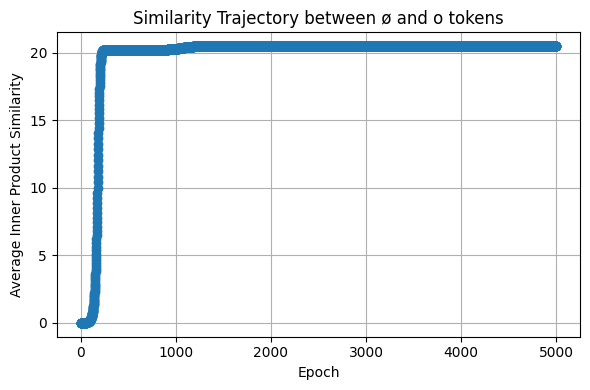

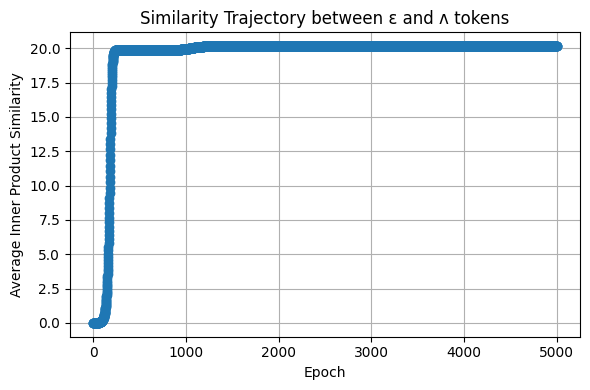

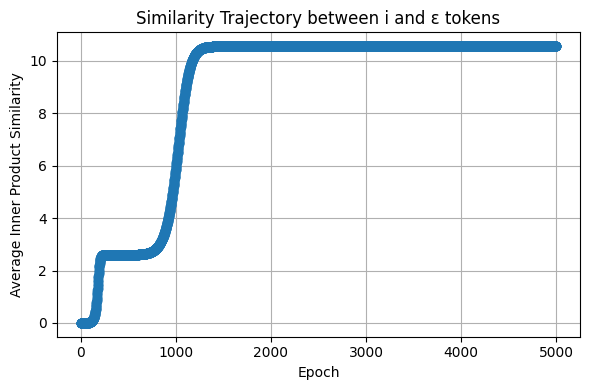

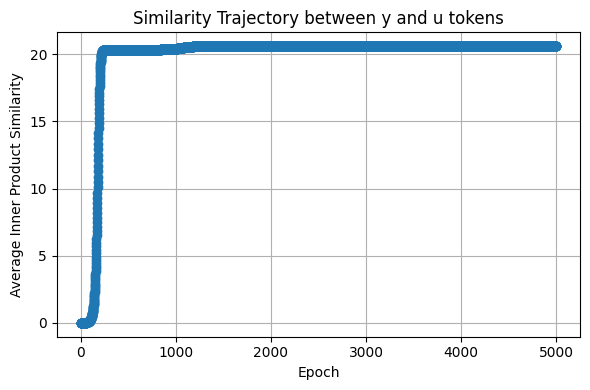

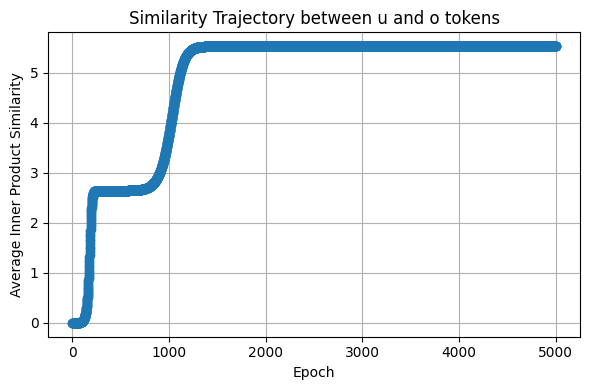

In [154]:
similarity_curves = {}
for contrast_pair in [("ø", "o"), ("ɛ", "ʌ"), ("i", "ɛ"), ("y", "u"), ("u", "o")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["testing_activations"], labels_test, label_a=label_a, label_b=label_b, 
                                                calculator=average_euclidean_distance)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [155]:
similarity_curves.keys()

dict_keys([('ø', 'o'), ('ɛ', 'ʌ'), ('i', 'ɛ'), ('y', 'u'), ('u', 'o')])

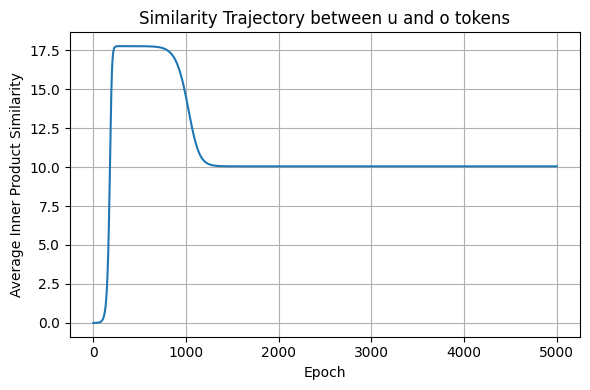

In [156]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[('y', 'u')] - similarity_curves[('i', 'ɛ')])[:])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_971751/1844846676.py:18: SyntaxWarning: invalid escape sequence '\g'
  marker='x', label='Actual ($\gamma = 0$)')
/tmp/ipykernel_971751/1844846676.py:28: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)


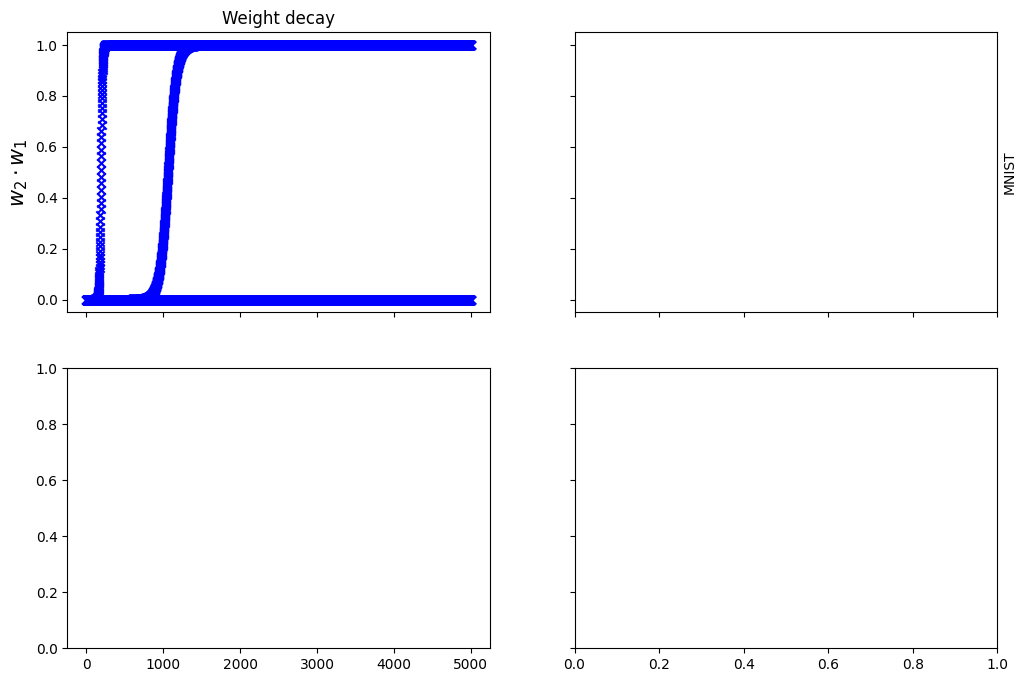

In [157]:
# create dynamics plot
slices = (0, 1, 2, 3)
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(12, 8), sharey='row', sharex='col')
axes = [ax1, ax2]

# get actual dynamics
actual_dynamics_mnist = recorded_models[0].strenghts.cpu().numpy()
# actual_dynamics_reg_mnist = recorded_models[1].strenghts.cpu().numpy()
# actual_dynamics_mnist = recorded_models[0].history['weights']['W1']
# actual_dynamics_reg_mnist = recorded_models[1].history['weights']['W1']
# actual_dynamics_noise_mnist = mnist_models[2].strenghts.cpu().numpy()

# plot simulated dynamics
x_p = np.arange(0, epochs+1, 1)
rangestart = 0
for s in slices:
    ax1.scatter(x_p[rangestart:], actual_dynamics_mnist[rangestart:, s], c='blue', 
                marker='x', label='Actual ($\gamma = 0$)')
    # ax1.scatter(x_p[rangestart:], actual_dynamics_reg_mnist[rangestart:, s], c='orange', 
    #             marker='x', label='Actual ($\gamma = $' + str(reg_param) + ')')
    # ax2.scatter(x_p, actual_dynamics_mnist[:, s], c='blue', 
    #             marker='x', label='Actual ($\sigma^2 = 0$)')
    # ax2.scatter(x_p, actual_dynamics_noise_mnist[:, s], c='darkgreen',
    #             marker='x', label='Actual ($\sigma^2 = $' + str(var_param) + ')')
    
    
# set plot titles and axis labels
ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)
ax1.set_title('Weight decay')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('MNIST')
plt.show()

In [158]:
import numpy as np


# Helper functions to compute theoretical learning dynamics
def dae_learning_dynamics(lam, var, gamma, N, n_epoch, learning_rate, u0):
    dynamics = []
    tau = N/learning_rate
    g = N*gamma
    xi = lam + N*var
    
    for t in range(n_epoch):
        E = np.exp((2*(lam - g)*t)/tau)
        num = (lam - g)*E
        denom = xi*(E - 1) + (lam - g)/u0
        uf = num/denom
        dynamics.append(uf)
    
    return np.asarray(dynamics)
  
def compute_correlation_matrix(x, y):
    mat = np.zeros((y.shape[1], x.shape[1]))
    for x_vec, y_vec in zip(x, y):
        mat += np.outer(y_vec, x_vec)
    return mat
  
def theoretical_learning_dynamics(X, y, n_epoch, lr, var, reg, u0 = 2.5e-7):
    dyns = np.zeros((1,X.shape[1]))
    corr_mat = compute_correlation_matrix(X, y)
    U, S, V = np.linalg.svd(corr_mat)
    dyns = dae_learning_dynamics(S, var, reg, X.shape[0], n_epoch, lr, u0)
    return dyns

### Case 4: Small contrasts

In [159]:
# training means and shared std
means_train = [
    # np.array([120.0, 320.0, 1650.0, 2250.0]),  # /y/
    # np.array([120.0, 320.0,  800.0, 2250.0]),  # /u/
    np.array([0.0, 0.0, 0.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 0.0, 5.0]),  # /i/
]
var_strength = 5.0  # Hz in all dimensions
vars_train = [var_strength] * len(means_train)
sizes_train = [100 // len(means_train)] * len(means_train)  # for example
tags_train = ["y", "i"]

means_test = [
    np.array([0.0, 5.0, -10.0, 0.0]),  # /ø/
    np.array([0.0, 5.0, 10.0, 0.0]),  # /o/
    np.array([0.0, 10.0, -10.0, 5.0]),  # /ɛ/
    np.array([0.0, 10.0, 10.0, 5.0]),  # /ʌ/
    np.array([0.0, 0.0, -10.0, 5.0]),  # /i/
    np.array([0.0, 0.0, -10.0, 0.0]),  # /y/
    np.array([0.0, 0.0, 10.0, 0.0]),  # /u/
]
vars_test = [var_strength] * len(means_test)
sizes_test = [50] * len(means_test)  # for example
tags_test = ["ø", "o", "ɛ", "ʌ", "i", "y", "u"]

data_train, labels_train = generate_gmm_data(d=4, n_components=len(tags_train), random_state=calendar.timegm(time.gmtime()), means=means_train, vars=vars_train, sizes=sizes_train, tags=tags_train)

data_test, labels_test = generate_gmm_data(d=4, n_components=len(tags_test), random_state=calendar.timegm(time.gmtime()) + 1, means=means_test, vars=vars_test, sizes=sizes_test, tags=tags_test)

In [160]:
# set parameters
num_samples = sum(sizes_train)
epochs = 5000
lr = 0.001
reg_param = 0.5
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

recorded_models = []

# convert to pytorch tensors
input_data = torch.from_numpy(data_train).float()

# set seed
# np.random.seed(123)
# torch.manual_seed(321)

# train autoencoder networks
# for t in range(num_trials):
t = 1
laeModel = LinearAutoEncoder()
laeModel.train(input_data, None, input_dim=4, 
                n_epoch=epochs, hidden_dim=hidden_dim, 
                learning_rate=lr, reg_param=reg[t], 
                noise='Gaussian', noise_scale=var[t], verbose=True, 
                Y=torch.from_numpy(data_test).float(), 
                Y_val=labels_test)
recorded_models.append(laeModel)

iteration:  0 training loss:  tensor(15.6311, device='cuda:0')
iteration:  100 training loss:  tensor(15.6311, device='cuda:0')
iteration:  200 training loss:  tensor(15.6311, device='cuda:0')
iteration:  300 training loss:  tensor(15.6308, device='cuda:0')
iteration:  400 training loss:  tensor(15.6228, device='cuda:0')
iteration:  500 training loss:  tensor(15.4473, device='cuda:0')
iteration:  600 training loss:  tensor(12.6771, device='cuda:0')
iteration:  700 training loss:  tensor(8.1602, device='cuda:0')
iteration:  800 training loss:  tensor(8.0268, device='cuda:0')
iteration:  900 training loss:  tensor(8.0264, device='cuda:0')
iteration:  1000 training loss:  tensor(8.0262, device='cuda:0')
iteration:  1100 training loss:  tensor(8.0254, device='cuda:0')
iteration:  1200 training loss:  tensor(8.0230, device='cuda:0')
iteration:  1300 training loss:  tensor(8.0151, device='cuda:0')
iteration:  1400 training loss:  tensor(7.9898, device='cuda:0')
iteration:  1500 training loss

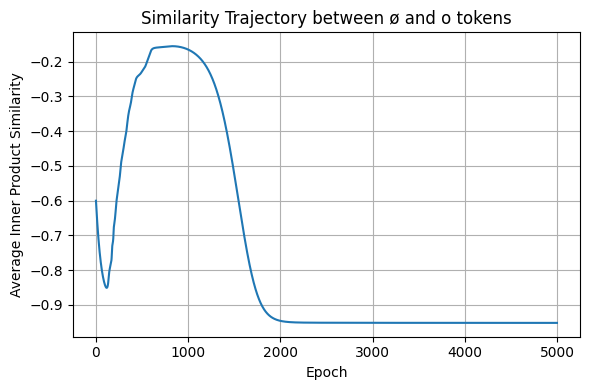

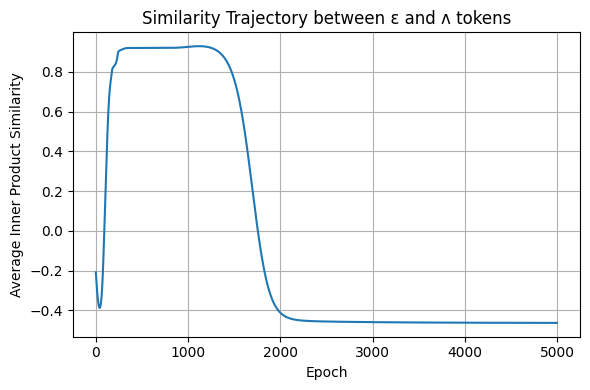

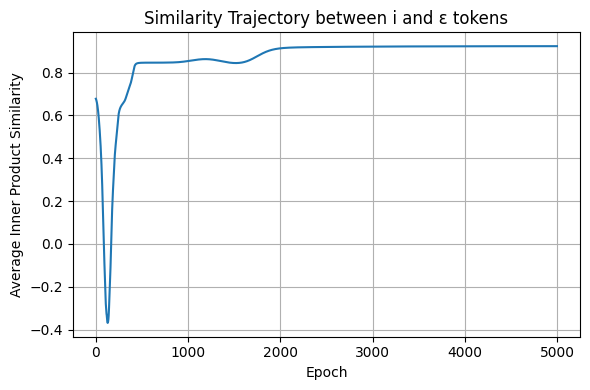

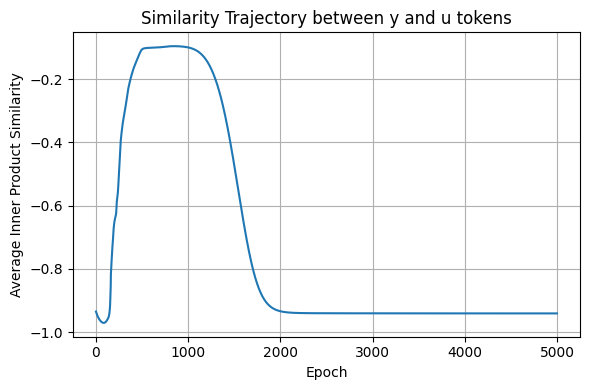

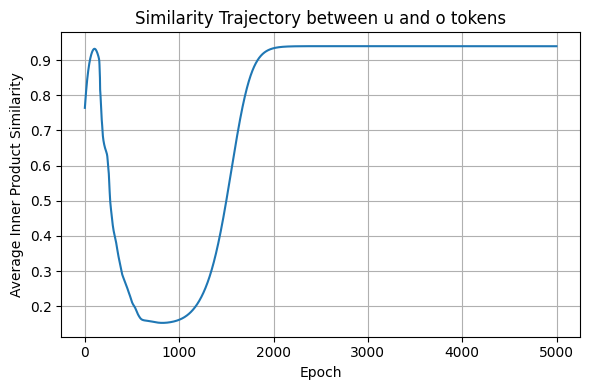

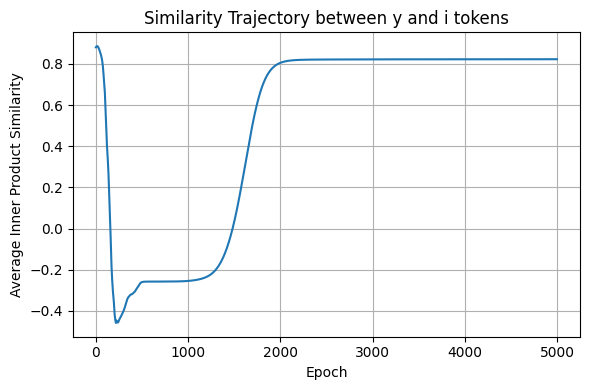

In [161]:
similarity_curves = {}
for contrast_pair in [("ø", "o"), ("ɛ", "ʌ"), ("i", "ɛ"), ("y", "u"), ("u", "o"), ("y", "i")]:
    label_a, label_b = contrast_pair
    similarity_curve = similarity_trajectory(recorded_models[0].history["testing_activations"], labels_test, label_a=label_a, label_b=label_b, 
                                              calculator=average_cosine_similarity)
    similarity_curve = np.array(similarity_curve)
    similarity_curves[contrast_pair] = similarity_curve

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(similarity_curve[0:])
    plt.xlabel('Epoch')
    plt.ylabel('Average Inner Product Similarity')
    plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [143]:
similarity_curves.keys()

dict_keys([('ø', 'o'), ('ɛ', 'ʌ'), ('i', 'ɛ'), ('y', 'u'), ('u', 'o'), ('y', 'i')])

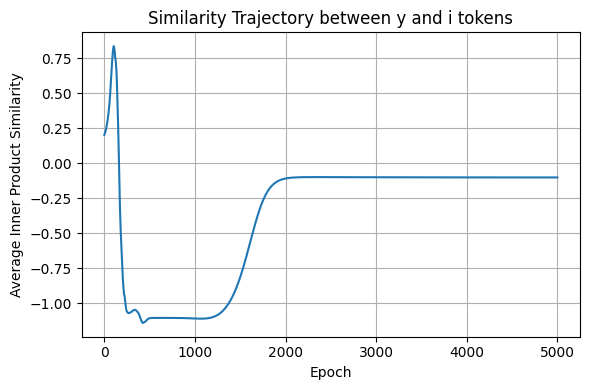

In [162]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot((similarity_curves[('y', 'i')] - similarity_curves[('i', 'ɛ')])[:])
plt.xlabel('Epoch')
plt.ylabel('Average Inner Product Similarity')
plt.title(f'Similarity Trajectory between {label_a} and {label_b} tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

In [145]:
# set parameters
num_samples = sum(sizes_train)
epochs = 5000
lr = 0.001
reg_param = 0.5
var_param = 0.5
reg = [0.0, reg_param, 0.0]
var = [0.0, 0.0, var_param]
num_trials = 2
hidden_dim = 2

<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:36: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_971751/1268316.py:23: SyntaxWarning: invalid escape sequence '\g'
  label='Theory ($\gamma = 0$)')
/tmp/ipykernel_971751/1268316.py:26: SyntaxWarning: invalid escape sequence '\g'
  marker='x', label='Actual ($\gamma = 0$)')
/tmp/ipykernel_971751/1268316.py:36: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)


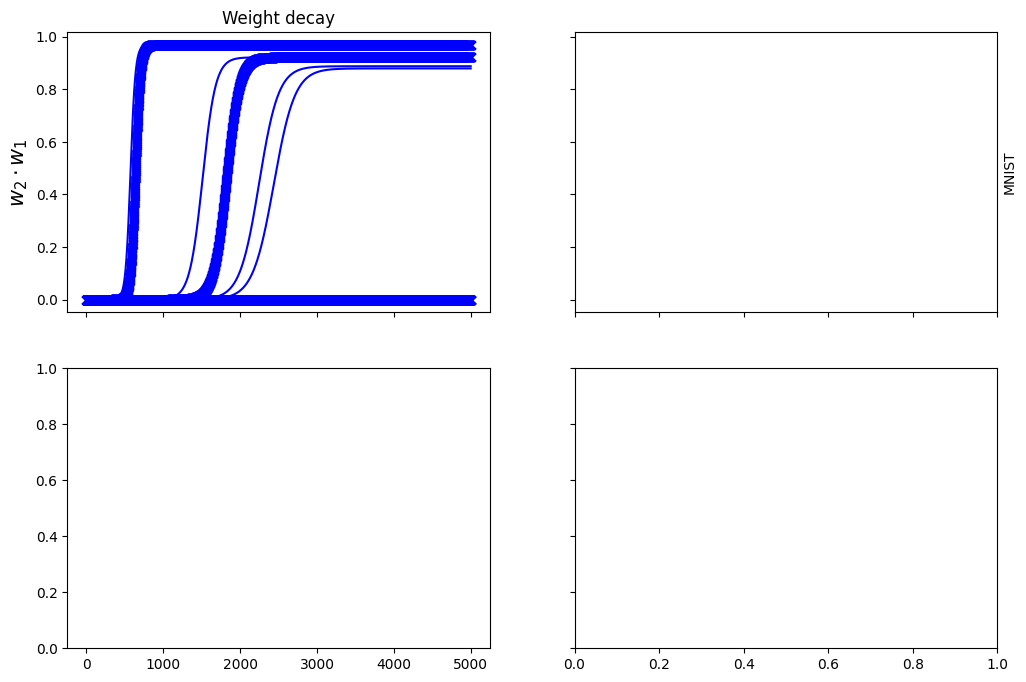

In [163]:
# create dynamics plot
slices = (0, 1, 2, 3)
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(12, 8), sharey='row', sharex='col')
axes = [ax1, ax2]

# get actual dynamics
actual_dynamics_mnist = recorded_models[0].strenghts.cpu().numpy()
# actual_dynamics_reg_mnist = recorded_models[1].strenghts.cpu().numpy()
# actual_dynamics_mnist = recorded_models[0].history['weights']['W1']
# actual_dynamics_reg_mnist = recorded_models[1].history['weights']['W1']
# actual_dynamics_noise_mnist = mnist_models[2].strenghts.cpu().numpy()
w0 = recorded_models[0].init
theoretical_dynamics_reg = theoretical_learning_dynamics(
                                data_train, 
                                data_train, 
                                n_epoch=epochs, lr=lr, var=0, 
                                reg=reg_param, u0 = w0)

# plot simulated dynamics
x_p = np.arange(0, epochs+1, 1)
rangestart = 0
ax1.plot(theoretical_dynamics_reg[:, slices], c='blue', 
         label='Theory ($\gamma = 0$)')
for s in slices:
    ax1.scatter(x_p[rangestart:], actual_dynamics_mnist[rangestart:, s], c='blue', 
                marker='x', label='Actual ($\gamma = 0$)')
    # ax1.scatter(x_p[rangestart:], actual_dynamics_reg_mnist[rangestart:, s], c='orange', 
    #             marker='x', label='Actual ($\gamma = $' + str(reg_param) + ')')
    # ax2.scatter(x_p, actual_dynamics_mnist[:, s], c='blue', 
    #             marker='x', label='Actual ($\sigma^2 = 0$)')
    # ax2.scatter(x_p, actual_dynamics_noise_mnist[:, s], c='darkgreen',
    #             marker='x', label='Actual ($\sigma^2 = $' + str(var_param) + ')')
    
    
# set plot titles and axis labels
ax1.set_ylabel('$w_2 \cdot w_1$', fontsize=15)
ax1.set_title('Weight decay')
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('MNIST')
plt.show()

### Plots for Checking

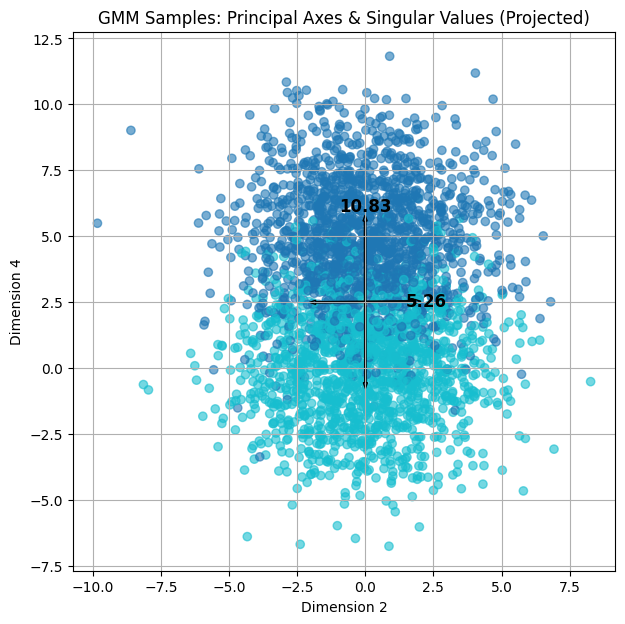

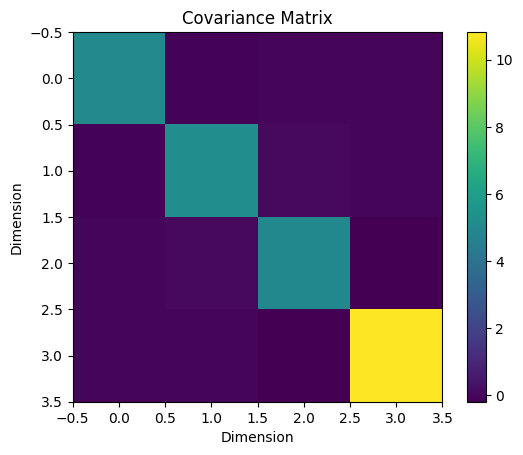

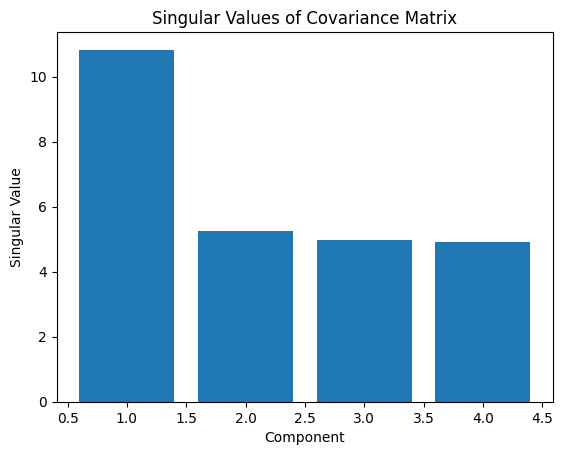

In [113]:
plot_2d_projection_with_principal_axes(data_train, labels_train, dim_x=1, dim_y=3)

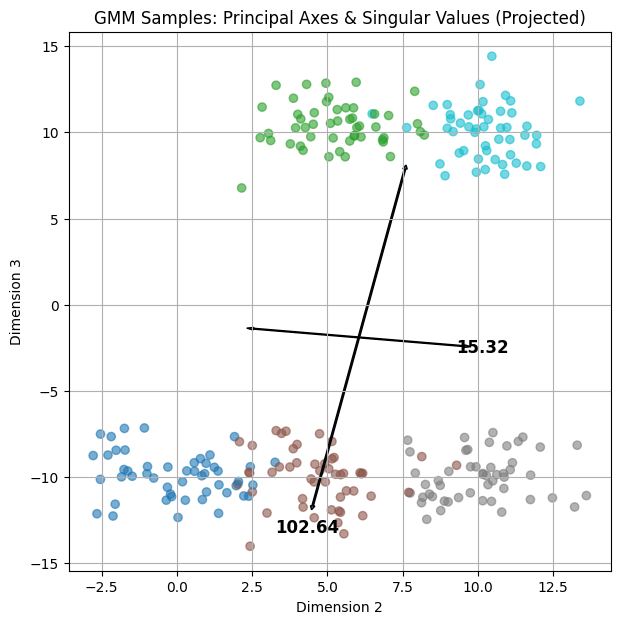

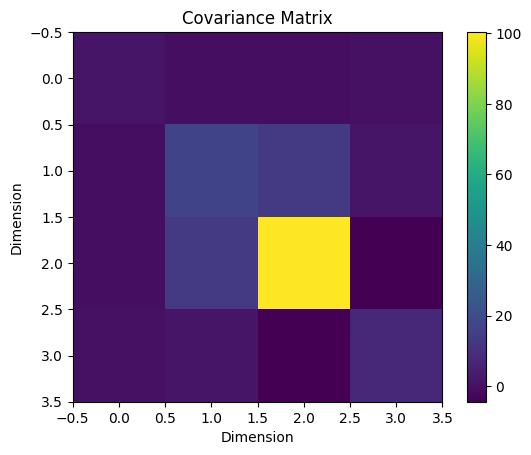

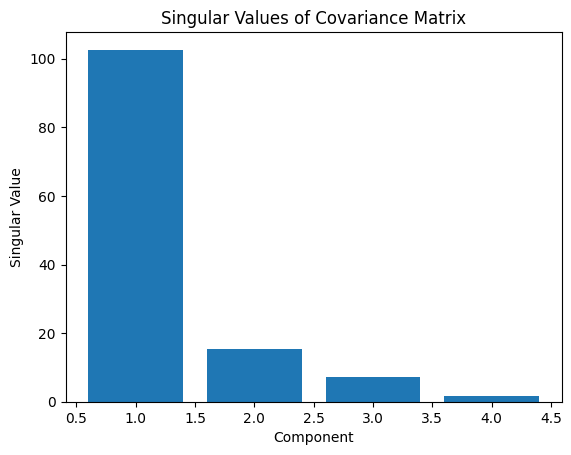

In [21]:
plot_2d_projection_with_principal_axes(data_test, labels_test, dim_x=1, dim_y=2)

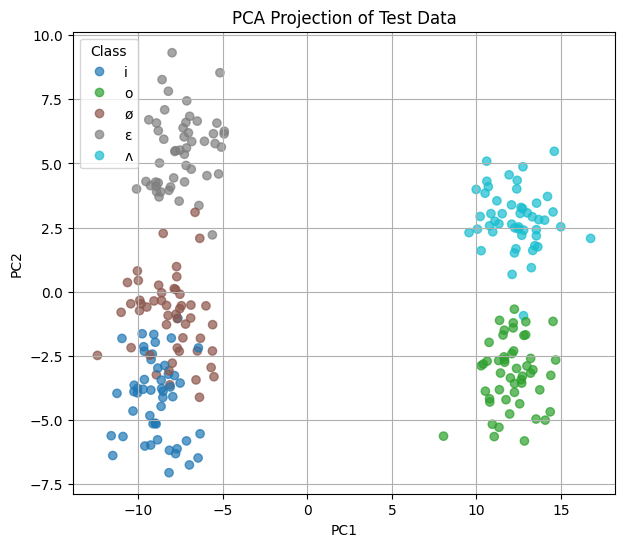

In [28]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_test)
label_names, labels_numeric = np.unique(labels_test, return_inverse=True)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_numeric, cmap='tab10', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of Test Data')
plt.grid(True)

# Matching legend
handles, _ = scatter.legend_elements(prop="colors", alpha=0.7)
plt.legend(handles, label_names, title='Class')
plt.show()